# Priming for use in CoLab

In [ ]:
!git clone https://github.com/jieunbyun/mbnpy_tutorial.git

import sys
sys.path.append('/content/mbnpy_tutorial')

!pip install mbnpy==0.1.9

In [15]:
from mbnpy import brc, cpm, variable, inference, branch
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [ ]:
df_schools = pd.read_excel(r"mbnpy_tutorial/data/Schools_Buildings_Fragility_Data_selected.xlsx")
#df_schools = pd.read_excel(r"data/Schools_Buildings_Fragility_Data_selected.xlsx") # for local case

In [17]:
print(df_schools)

      School Build code   Function  No. of Classrooms      mean       std
0   School A        A01  Classroom                 24  0.764607  0.276836
1   School A        A02  Classroom                 22  1.152667  0.302997
2   School A        A03  Classroom                 16  1.152667  0.302997
3   School A        A04  Classroom                 10  1.383200  0.302997
4   School A        A05  Classroom                  8  1.067485  0.275982
5   School A        A06  Classroom                  9  0.849689  0.303634
6   School A        A07  Classroom                  4  1.383200  0.302997
7   School A        A08  Classroom                  3  1.067485  0.275982
8   School A        A09  Classroom                  2  1.560711  0.269233
9   School A        A10  Classroom                  2  0.564000  0.360000
10  School A        A11  Classroom                  2  1.067485  0.275982
11  School B        B01  Classroom                  2  1.152667  0.302997
12  School B        B02  Classroom    

In [18]:
school_names = ['School A', 'School B']

print(f"Building codes (=component names):")
build_names = {}
for sc in school_names:
    df_school1 = df_schools[df_schools['School'] == sc]
    build_names[sc] = df_school1['Build code'].tolist()
    print(f"{sc}: {build_names[sc]}")

Building codes (=component names):
School A: ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11']
School B: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09']


In [19]:
pga_g = 0.4 # 2500-year return period

df_schools['pf'] = df_schools.apply(lambda row: norm.cdf(math.log(pga_g), math.log(row['mean']), row['std']), axis=1)
print(df_schools[['Build code', 'mean', 'std', 'pf']])

   Build code      mean       std            pf
0         A01  0.764607  0.276836  9.632398e-03
1         A02  1.152667  0.302997  2.388121e-04
2         A03  1.152667  0.302997  2.388121e-04
3         A04  1.383200  0.302997  2.113317e-05
4         A05  1.067485  0.275982  1.877448e-04
5         A06  0.849689  0.303634  6.545247e-03
6         A07  1.383200  0.302997  2.113317e-05
7         A08  1.067485  0.275982  1.877448e-04
8         A09  1.560711  0.269233  2.132807e-07
9         A10  0.564000  0.360000  1.699366e-01
10        A11  1.067485  0.275982  1.877448e-04
11        B01  1.152667  0.302997  2.388121e-04
12        B02  1.300592  0.269233  5.947142e-06
13        B03  1.300592  0.269233  5.947142e-06
14        B04  1.067485  0.275982  1.877448e-04
15        B05  0.521758  0.396797  2.515215e-01
16        B06  1.699378  0.303634  9.483184e-07
17        B07  1.300592  0.269233  5.947142e-06
18        B08  0.849689  0.303634  6.545247e-03
19        B09  1.383200  0.302997  2.113

# Build MBN

In [20]:
varis = {}
cpms = {}
probs = {} # for later use in BRC algorithm
for sc in school_names:
    df_school1 = df_schools[df_schools['School'] == sc]

    varis[sc] = {}
    cpms[sc] = {}
    probs[sc] = {}
    for b in build_names[sc]:
        n_class = df_school1[df_school1['Build code'] == b]['No. of Classrooms'].values[0]
        n_class = int(n_class)

        varis[sc][b] = variable.Variable(name = b, values = [0, n_class]) # State 0 stands for 0 capacity, 1 for full capacity

        pf_b = df_school1[df_school1['Build code'] == b]['pf'].values[0]
        pf_b = float(pf_b)
        probs[sc][b] = {0: pf_b, 1: 1.0-pf_b}
        cpms[sc][b] = cpm.Cpm(variables = [varis[sc][b]],
                              no_child = 1,
                              C = np.array([[0], [1]]),
                              p = np.array([pf_b, 1.0-pf_b]))

    # system event
    varis[sc]['school'] = variable.Variable(name = 'school', values = ['f', 's']) # 0 for failure and 1 for success (it is good practice to set worse states to lower indices)
    cpms[sc]['school'] = cpm.Cpm(variables = [varis[sc]['school']] + [varis[sc][b] for b in build_names[sc]],
                                 no_child = 1)

# System function

In [ ]:
def count_classrooms(comps_st, school_name = 'School A', thresh = 0.7):
    """
    Components are the school buildings
    Return 's' if the available number of classrooms is greater than or equal to the threshold * total number of classrooms;
    return 'f' otherwise.
    """

    total_rooms = sum(varis[school_name][b].values[1] for b in build_names[school_name])

    avail_rooms = 0
    for comp, st in comps_st.items():
        comp_capa = varis[school_name][comp].values[st]
        avail_rooms += comp_capa

    if avail_rooms >= total_rooms * thresh:
        sys_st = 's'

        all_rooms_dict = {comp: varis[school_name][comp].values[1] for comp in build_names[school_name]}
        all_rooms_dict = {k: v for k, v in sorted(all_rooms_dict.items(), key=lambda item: item[1], reverse=True)}

        min_comps_st = {}
        room_count = 0
        for k, v in all_rooms_dict.items():
            if comps_st[k] == 1:
                room_count += v
                min_comps_st[k] = 1
                if room_count >= total_rooms * thresh:
                    break
    else:
        sys_st = 'f'
        min_comps_st = None # it's not straightforward to find the minimal 'failure' conditions
    
    return avail_rooms, sys_st, min_comps_st


Let's test a few examples.

In [23]:
# Example 1
comps_st = {b: 1 for b in build_names['School A']}  # all components are in 'success' state
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='School A', thresh=0.7)
cap_dict = {k: varis['School A'][k].values[v] for k, v in min_comps_st.items()}
print(f"Example 1: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}, with capacities {cap_dict}")

# Example 2
comps_st['A01'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='School A', thresh=0.7)
cap_dict = {k: varis['School A'][k].values[v] for k, v in min_comps_st.items()}
print(f"Example 2: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}, with capacities {cap_dict}")

# Example 3
comps_st['A02'] = 0
avail_rooms, sys_st, min_comps_st = count_classrooms(comps_st, school_name='School A', thresh=0.7)
print(f"Example 3: {avail_rooms} rooms available, system state: {sys_st}, minimal components state: {min_comps_st}")

Example 1: 102 rooms available, system state: s, minimal components state: {'A01': 1, 'A02': 1, 'A03': 1, 'A04': 1}, with capacities {'A01': 24, 'A02': 22, 'A03': 16, 'A04': 10}
Example 2: 78 rooms available, system state: s, minimal components state: {'A02': 1, 'A03': 1, 'A04': 1, 'A06': 1, 'A05': 1, 'A07': 1, 'A08': 1}, with capacities {'A02': 22, 'A03': 16, 'A04': 10, 'A06': 9, 'A05': 8, 'A07': 4, 'A08': 3}
Example 3: 56 rooms available, system state: f, minimal components state: None


# System reliability analysis using BRC

Now we apply BRC algorithm to quantify P(School | building1, building2, ...).

In [ ]:
sc = 'School A'

sys_fun = lambda comps_st: count_classrooms(comps_st, school_name=sc, thresh=0.7)
brs, rules, sys_res, monitor = brc.run(probs[sc], sys_fun)

brc.save_brc_data(rules, brs, sys_res, monitor, output_folder = "brc_data", fname_prefix=sc)

[System function runs 10]..
The # of found non-dominated rules (f, s): 10 (4, 6)
Probability of branchs (f, s, u): (6.9412e-05, 1.00e+00, 5.6393e-06)
The # of branches (f, s, u), (min, avg) len of rf: 27 (8, 5, 14), (2, 2.00)
Elapsed seconds (average per round): 3.25e-02 (3.25e-03)
[System function runs 20]..
The # of found non-dominated rules (f, s): 20 (7, 13)
Probability of branchs (f, s, u): (7.1218e-05, 1.00e+00, 1.0551e-07)
The # of branches (f, s, u), (min, avg) len of rf: 47 (9, 15, 23), (2, 2.00)
Elapsed seconds (average per round): 7.68e-02 (3.84e-03)
[System function runs 30]..
The # of found non-dominated rules (f, s): 30 (11, 19)
Probability of branchs (f, s, u): (7.1231e-05, 1.00e+00, 2.1524e-10)
The # of branches (f, s, u), (min, avg) len of rf: 70 (19, 24, 27), (2, 2.36)
Elapsed seconds (average per round): 1.41e-01 (4.69e-03)
[System function runs 40]..
The # of found non-dominated rules (f, s): 40 (17, 23)
Probability of branchs (f, s, u): (7.1231e-05, 1.00e+00, 1.415

Branches need to be converted to Cmatrix of P(School | building1, building2, ...).

In [25]:
C_sc = branch.get_cmat(brs, {b: varis[sc][b] for b in build_names[sc]})
C_sc = C_sc[C_sc[:,0]!=2] # remove miscellenous unknown branches

p_sc = np.ones((C_sc.shape[0],1))

cpms[sc]['school'].C = C_sc
cpms[sc]['school'].p = p_sc

# Inference

P(School) = sum_{B_1, B_2, ...} P(School | B_1, B_2, ...) P(B_1) P(B_2) ...

In [26]:
var_elim_order = [b for b in build_names[sc]]

Msys = inference.variable_elim(cpms[sc], var_elim_order)
print(Msys)

<CPM representing P(school | ) at 0x26570d872c0>
+----------+-------------+
|   school [ ]           p |
+==========+=============+
|        1 [ ] 0.999929    |
+----------+-------------+
|        0 [ ] 7.12313e-05 |
+----------+-------------+


CPIM_n = P(B_n = 0 | School = 0 ) = P(B_n = 0, School = 0) / P(School = 0)

In [27]:
cpim = {}
cpim[sc] = {}

P_s0 = Msys.get_prob(['school'], [0])
for b in build_names[sc]:
    Msys_b = inference.variable_elim(cpms[sc], [b_ for b_ in build_names[sc] if b_ != b])
    P_s0_b0 = Msys_b.get_prob(['school', b], [0, 0])

    cpim_b = P_s0_b0 / P_s0
    cpim[sc][b] = cpim_b

print(f"CPIM for {sc}:")
for b in build_names[sc]:
    print(f"{b}: {cpim[sc][b]}")

CPIM for School A:
A01: 0.9773001019719219
A02: 0.05498911468430467
A03: 0.03309141685709643
A04: 0.0029284191476553097
A05: 0.025501915579853485
A06: 0.9068312742555341
A07: 2.184789132889829e-05
A08: 0.000189183305078278
A09: 2.1440769926561663e-07
A10: 0.17002470576781717
A11: 0.00018873589027914572


In [28]:
print(list(probs[sc].values()))

[{0: 0.009632398326182403, 1: 0.9903676016738175}, {0: 0.00023881209453266463, 1: 0.9997611879054673}, {0: 0.00023881209453266463, 1: 0.9997611879054673}, {0: 2.113316655161262e-05, 1: 0.9999788668334484}, {0: 0.00018774475670805654, 1: 0.999812255243292}, {0: 0.006545246844305206, 1: 0.9934547531556948}, {0: 2.113316655161262e-05, 1: 0.9999788668334484}, {0: 0.00018774475670805654, 1: 0.999812255243292}, {0: 2.132807015830755e-07, 1: 0.9999997867192985}, {0: 0.16993659429241254, 1: 0.8300634057075875}, {0: 0.00018774475670805654, 1: 0.999812255243292}]


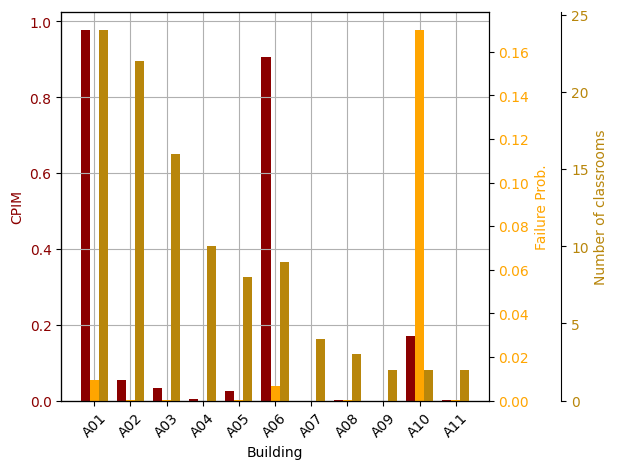

In [29]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

keys = list(cpim[sc].keys())
x = range(len(keys))
bar_width = 0.25

# First bar (left axis)
ax1.bar([i - bar_width for i in x], list(cpim[sc].values()), 
        width=bar_width, color='darkred', label='CPIM')
ax1.set_ylabel('CPIM', color='darkred')
ax1.tick_params(axis='y', labelcolor='darkred')
ax1.set_xticks(x)
ax1.set_xticklabels(keys, rotation=45)
ax1.set_xlabel('Building')
ax1.grid()

# Second bar (right axis)
ax2 = ax1.twinx()
ax2.bar(x, [pr[0] for pr in probs[sc].values()], 
        width=bar_width, color='orange', label='Failure Prob')
ax2.set_ylabel('Failure Prob.', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Third bar (new axis, shifted right)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.17))  # move third axis further right
ax3.bar([i + bar_width for i in x], [varis[sc][b].values[1] for b in build_names[sc]], 
        width=bar_width, color='darkgoldenrod', label='Third Metric')
ax3.set_ylabel('Number of classrooms', color='darkgoldenrod')
ax3.tick_params(axis='y', labelcolor='darkgoldenrod')

plt.tight_layout()
plt.show()


The results above show how component importance is determined by the interplay of failure probability and functional contribution (i.e. number of classrooms).

# Take away

1. School reliability can be efficiently quantified using MBN and BRC.
2. Various probabilistic quantities can be computed.

# Future exercises for self study

1. Analysis of School B
    - The same codes above can be used.
2. Combination with transport. (solution to be shared.)
    - Consider the school-transport network, where there are two bridges that may fail, each with failure probability of 0.07302 and 0.1307. The system failure event of interest is that the school A (destination) is not accessible from the city on the other side of river (origin) by either the disconnectivity of the road network or the failure of the school complex. What is the probability of system failure? 

<p align="center">
<img src="data/CDO school bridge network.png" width="600">
</p>